In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time
from scipy import stats

In [2]:
lat = np.array([49.9166666666664 - i * 0.0416666666667 for i in range(357)])
lon = np.array([-105.0416666666507 + i * 0.0416666666667 for i in range(722)])
Lon, Lat = np.meshgrid(lon, lat)

mask = np.load('./var/MWmask.npy')

tmin81 = np.load('./prism/mw_tmin/1981_tmin.npz')['tmin']
t, yy, xx = tmin81.shape
# y*x

In [3]:
Lon = np.array([[(Lon[i:(yy-yy%4):4,j:(xx-xx%4):4]) for j in range(4)] for i in range(4)]).mean(axis=(0,1))
Lat = np.array([[(Lat[i:(yy-yy%4):4,j:(xx-xx%4):4]) for j in range(4)] for i in range(4)]).mean(axis=(0,1))
mask = np.array([[(np.where(mask, 1, np.nan)[i:(yy-yy%4):4,j:(xx-xx%4):4]) for j in range(4)] for i in range(4)]).mean(axis=(0,1))

In [4]:
# countna = ['count44March.npy', 'count44April.npy', 'count44May.npy']
mi = 0
count = np.load(f'./var/Min0DaysCount.npy')[:, mi, :, :]
count = np.array([[(count[:, i:(yy-yy%4):4,j:(xx-xx%4):4]) for j in range(4)] for i in range(4)]).mean(axis=(0,1))
t, y, x = count.shape
X = count.reshape((t, y*x))
flag = np.where(np.isnan(mask.reshape(-1)), False, True)
X = X[:,flag]
X = (X - X.mean(axis=0)) / X.std(axis=0)

# pd.DataFrame(X).to_csv('./var/March_4.csv', index=False)

# np.count_nonzero(np.isnan(X))

In [5]:
import scipy.io
weight = scipy.io.loadmat('./var/weightsmapFreezingDayMarch3by2.mat')['M']
c = scipy.io.loadmat('./var/nodeCoordFreezingDayMarch3by2.mat')['c'][0]

In [6]:
# > map$unit.classif
#  [1] 4 5 4 4 5 3 2 3 1 7 7 8 3 8 5 4 4 5 5 5 5 4 3 4 1 3 5 6 3 7 7 5 9 7 3 3 3 5
# > mean(map$distances)
# [1] 3898.436

mon = ['March', 'April', 'May']

# SOMweight = pd.read_table(f'./var/{mon[mi]}SOMweight.txt', delim_whitespace=True)
weightmap = np.zeros((6, y, x)) * np.nan
for i in range(6):
    temp = np.zeros(y*x) * np.nan
    temp[flag] = weight[i, :]
    weightmap[i, :, :] = temp.reshape((y, x))

In [7]:
import statsmodels.api as sm
# winner_coordinates = pd.read_table(f'./var/{mon[mi]}SOMtimeseries.txt', delim_whitespace=True).values.T[0]
# rsqaured = np.zeros(38)
# for i in range(38):
#     X = pd.DataFrame({'node':weightmap[int(winner_coordinates[i])-1, :, :].reshape(y*x)})
#     X = pd.DataFrame({'node':weightmap[int(winner_coordinates[i])-1, :, :].reshape(y*x)})
#     Y = pd.DataFrame({'year':may[i, :, :].reshape(y*x)})
#     result = sm.OLS(X['node'], Y['year'], missing='drop').fit()
#     rsqaured[i] = result.rsquared_adj
# rsqaured.mean()
rsqaured = np.zeros(38)
for i in range(38):
    XX = pd.DataFrame({'node':weight[c[i]-1, :]})
    Y = pd.DataFrame({'year':X[i, :]})
    result = sm.OLS(XX['node'], Y['year'], missing='drop').fit()
    rsqaured[i] = result.rsquared_adj
rsqaured.mean()

0.4823266839526517

In [8]:
# winner_coordinates = pd.read_table(f'./var/{mon[mi]}SOMtimeseries.txt', delim_whitespace=True).values.T[0]
cc = np.zeros(6)
for yl in range(38):
#     pos = winner_coordinates[yl]
    pos = c[yl]
    cc[pos-1] = cc[pos-1] + 1
cc = cc / 38
cc

array([0.28947368, 0.02631579, 0.36842105, 0.21052632, 0.02631579,
       0.07894737])

In [37]:
ccy = np.zeros((9, 39))
for yl in range(39):
#     pos = winner_coordinates[yl]
    pos = c[yl]
    ccy[pos-1, yl] = 1
X = np.linspace(1,39,39)
ccy = np.array([ccy[i, :] * (i+1) for i in range(6)])
plt.figure(figsize=(8, 6))
[plt.bar(X, ccy[i, :], facecolor='k') for i in range(6)]
[plt.bar(X, ccy[i, :]-1, facecolor='w') for i in range(6)]
plt.ylim(0, 6)
plt.yticks([i+1 for i in range(6)])
plt.grid(True)
plt.xlim(0, 39)
plt.xticks([i for i in range(1, 39, 2)], [str(i+1981)[2:] for i in range(0, 39, 2)])
plt.xlabel('Year', fontweight='bold')
plt.title(f'Occurrence time series for each SOM pattern in {mon[mi]}', fontsize=14, fontweight='bold')
plt.savefig(f'./plot/Composite/{mon[mi]}SOMTimeSeries.png', bbox_inches='tight')
plt.close()
# plt.show()

In [28]:
def color_PositiveNegative(s):
    if s[0] == '-':
        color = 'blue'
        if s[-1] == '*':
            color = 'deepskyblue'
    else:
        color = 'red'
        if s[-1] == '*':
            color = 'magenta'
    return 'color: %s' % color

from scipy import stats
ccy = np.zeros((6, 38))
for yl in range(38):
#     pos = winner_coordinates[yl]
    pos = c[yl]
    ccy[pos-1, yl] = 1
X = np.linspace(1,38,38)
slope = np.zeros(6)
pvalue = np.zeros(6)
for ni in range(6):
    r = stats.linregress(X, ccy[ni,:])
    slope[ni] = r.slope
    pvalue[ni] = r.pvalue

table = [[] for i in range(6)] 
for ni in range(6):
    if pvalue[ni] < .05:
        table[ni] = f'{(slope[ni]):.4f}**'
    elif pvalue[ni] < .1:
        table[ni] = f'{(slope[ni]):.4f}*'
    else:
        table[ni] = f'{(slope[ni]):.4f}'
df = pd.DataFrame({'Trend (per year)':table}).T
df = df.rename(columns={i:f'Node {i+1}' for i in range(6)})
df.style.applymap(color_PositiveNegative)

,Node 1,Node 2,Node 3,Node 4,Node 5,Node 6
Trend (per year),0.0111,-0.0023,0.0007,-0.0090,-0.0005,0.0001


In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs
import cartopy

In [14]:
extent = [-105, -75, 34, 49]
fig, axs = plt.subplots(3, 2, figsize=(12, 11))
for i in range(6):
    ax = plt.subplot(3,2,i+1, projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
    ax.set_extent(extent)
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
    ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

    levels = MaxNLocator(nbins=100).tick_values(-2, 2)
    cmap = plt.get_cmap('bwr')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc = plt.pcolormesh(Lon, Lat, weightmap[i, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    plt.title(f'Node {i+1} ({cc[i]*100:.2f}%)', fontweight='bold')

plt.suptitle(f'SOM patterns of freezing days in {mon[mi]} for 3by2 grid from 1981 to 2018', fontsize=15, fontweight='bold')
fig.subplots_adjust(bottom=0, top=0.9, left=0.1, right=0.9,
                wspace=0.05, hspace=0.02)
cb_ax = fig.add_axes([0.905, 0.021, 0.01, 0.87])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(-3, 3.2, .5), extend='both')
cb_ax.tick_params(labelsize=12)
plt.savefig(f'./plot/Composite/SOM{mon[mi]}.png', bbox_inches='tight')
plt.close()

In [36]:
temp0 = []
for ni in range(6):
    temp0.append(slope[ni]*weight[ni, :])
    
Fslope = np.load('./var/Min0DaysSlope.npy')
SOMtrend3by2Rs = []
for ni in range(6):
    XX = pd.DataFrame({'SOMtrend':temp0[ni]})
    Y = pd.DataFrame({'Trend':
        np.array([[(Fslope[0, i:(yy-yy%4):4,j:(xx-xx%4):4]) for j in range(4)] for i in range(4)]).mean(axis=(0,1)).reshape(y*x)[flag]})
    result = sm.OLS(XX['SOMtrend'], Y['Trend'], missing='drop').fit()
    SOMtrend3by2Rs.append(result.rsquared_adj)
SOMtrend3by2Rs
df = pd.DataFrame({'Trend explained':[str(SOMtrend3by2Rs[i])[:6] for i in range(6)]}).T
df = df.rename(columns={i:f'Node {i+1}' for i in range(6)})
df

,Node 1,Node 2,Node 3,Node 4,Node 5,Node 6
Trend explained,0.2858,0.0338,0.2111,0.1242,0.0103,0.1898


In [15]:
SOMsumtrend = []
for ni in range(6):
    SOMsumtrend.append(slope[ni]*weight[ni, :])
SOMsumtrend = np.array(SOMsumtrend).sum(axis=0)
SOMtrend = np.zeros(y*x) * np.nan
SOMtrend[flag] = SOMsumtrend
SOMtrend = SOMtrend.reshape((y, x))

In [16]:
slope = np.load('./var/Min0DaysSlope.npy')
XX = pd.DataFrame({'SOMtrend':SOMtrend.reshape(y*x)[flag]})
Y = pd.DataFrame({'Trend':
    np.array([[(slope[0, i:(yy-yy%4):4,j:(xx-xx%4):4]) for j in range(4)] for i in range(4)]).mean(axis=(0,1)).reshape(y*x)[flag]})
result = sm.OLS(XX['SOMtrend'], Y['Trend'], missing='drop').fit()
result.rsquared_adj

0.23602821711691757

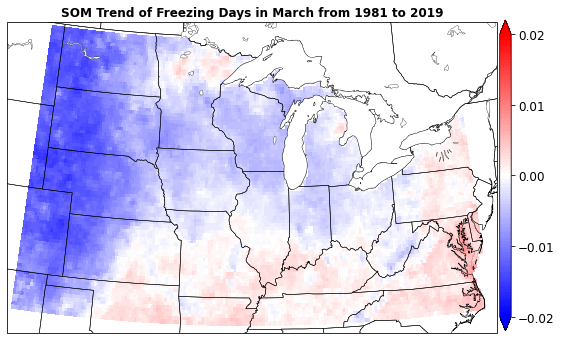

In [17]:
extent = [-105, -75, 34, 49]
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
ax = plt.subplot(1,1,1, projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

levels = MaxNLocator(nbins=100).tick_values(-.02, .02)
cmap = plt.get_cmap('bwr')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, SOMtrend, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
plt.title(f'SOM Trend of Freezing Days in {mon[mi]} from 1981 to 2019', fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(-.03, .04, .01), extend='both')
cb_ax.tick_params(labelsize=12)

In [28]:
# mapsize=[5, 5]
# sm = SOMFactory.build(X, mapsize, mask=None, mapshape='planar', lattice='rect', normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  # this will use the default parameters, but i can change the initialization and neighborhood methods
# sm.train(n_job=1, verbose='info', train_rough_len=2, train_finetune_len=5)

# # quantization_error = np.mean(sm._bmu[1])
# # quantization_error
# dir(sm)
# sm.find_k_nodes

# from sompy.visualization.mapview import View2D
# view2D  = View2D(10,10,"may",text_size=12)
# view2D.show(sm, col_sz=4, which_dim="all")

# # c = sompy.mapview.View2DPacked()
# v = sompy.mapview.View2DPacked(2, 2, 'test',text_size=8)  
# #first you can do clustering. Currently only K-means on top of the trained som
# cl = sm.cluster(n_clusters=25)
# print(cl)
# getattr(sm, 'cluster_labels')

# v.show(sm, what='cluster')
# h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
# h.show(som)

# dir(sm)
# # sm.calculate_quantization_error()
# # sm._calculate_ms_and_mpd()

# from minisom import MiniSom
# som = MiniSom(3, 3, X.shape[1], sigma=.1, learning_rate=0.2)
# som.pca_weights_init(X)
# som.train_batch(X, 50000, verbose=True)  # random training

# win_map = som.win_map(X)
# sum([len(win_map[key]) for key in win_map.keys()])

# import pickle
# # with open('som.p', 'wb') as outfile:
# #     pickle.dump(som, outfile)

# with open('som.p', 'rb') as infile:
#     som = pickle.load(infile)